# Spatial Operations

## Introduction

Spatial Operations are functions that _"create new spatial data from specified input data"_ ([source](https://developers.arcgis.com/python/guide/part3-spatial-operations-on-geometries/)). In this notebook we'll explore some examples of spatial operations, using ['John Snow data'](https://github.com/jamesdamillington/john-snow) about the [1854 cholera outbreak in Soho](https://en.wikipedia.org/wiki/1854_Broad_Street_cholera_outbreak) to create:

1. <a href="#diff">differences</a> (between polygons) 
2. <a href="#inter">intersections</a> (of polygons)
3. <a href="#union">unions</a> (of polygons)

Finally, we'll <a href="#combine">combine</a> multiple operations together. 

For these operations we will use methods from the [Shapely](https://shapely.readthedocs.io/) package, alongside [GeoPandas](https://geopandas.org/). This notebook builds on a previous notebook on [Spatial Relations](https://github.com/jamesdamillington/john-snow/blob/main/code/python/Relations.ipynb).

## Setup

First, import the necessary packages.

In [1]:
import shapely
import geopandas as gpd
import matplotlib.pyplot as plt

import pygeos
print(pygeos.__version__)
print(gpd.__version__)
print(shapely.__version__)

0.8
0.9.0
1.7.1


Load data

In [2]:
pumps = gpd.read_file('../../data/csds/snow7/pumps.shp')  #point locations of pumps
blocks = gpd.read_file('../../data/dani/polys.shp')       #polygons delineating blocks of buildings

And quickly plot the data to visualise what we are working with:
- blue points are locations of water pumps
- grey polygons are footprints of buildings. 

<AxesSubplot:>

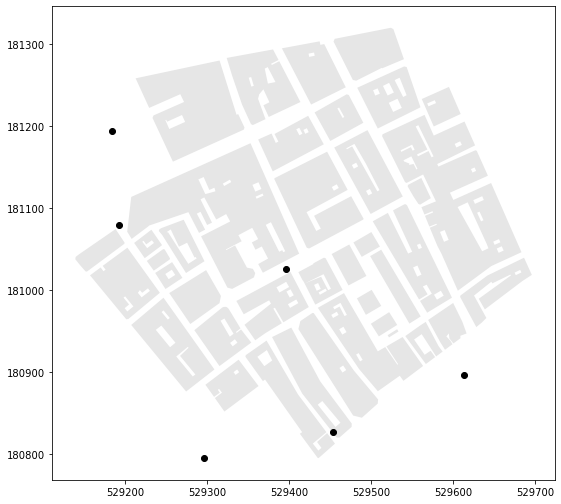

In [3]:
f, ax = plt.subplots(1, figsize=(9, 9))
blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
pumps.plot(ax=ax, color='black')

Note that the data are projected with CRS [`EPSG:27700`](https://epsg.io/27700) which is _OSGB 1936 / British National Grid_ with units in metres. 

# Buffers <a name ="buff"></a> 

Buffers are an area within a given distance of another geometric object (such as a point or a line). The Shapely [`buffer` method](https://shapely.readthedocs.io/en/stable/manual.html#object.buffer):

> Returns an approximate representation of all points within a given distance of the this geometric object.

Using `buffer` with our _pumps_ GeoDataFrame applies the method to the geometric objects in the `geometry` Series:

In [4]:
pumps['buffer']=pumps.buffer(200)

We have just created 200m buffers around all the points in the _pumps_ GeoDataFrame, assigning them to a new Series names _buffer_. To check this:

In [5]:
pumps

,ID,x,y,name,geometry,buffer
0,1,529396.539395,181025.063047,Broad St Pump,POINT (529396.539 181025.063),"POLYGON ((529596.539 181025.063, 529595.576 18..."
1,2,529192.537868,181079.391380,Great Malborough Pump,POINT (529192.538 181079.391),"POLYGON ((529392.538 181079.391, 529391.575 18..."
2,3,529183.739766,181193.735013,Ramilies Place Pump,POINT (529183.740 181193.735),"POLYGON ((529383.740 181193.735, 529382.777 18..."
3,5,529613.205238,180896.804121,Rupert St Pump,POINT (529613.205 180896.804),"POLYGON ((529813.205 180896.804, 529812.242 18..."
4,6,529453.585995,180826.353152,Brewer St Pump,POINT (529453.586 180826.353),"POLYGON ((529653.586 180826.353, 529652.623 18..."
5,8,529296.104419,180794.849037,Warwick St Pump,POINT (529296.104 180794.849),"POLYGON ((529496.104 180794.849, 529495.141 18..."


Buffers are an operation, but they are examined in detail in the [Spatial Relations notebook](https://github.com/jamesdamillington/john-snow/blob/main/code/python/Relations.ipynb). 

We'll visualise our buffers, before moving on to use the buffer polygons to investigate other operations:

<AxesSubplot:>

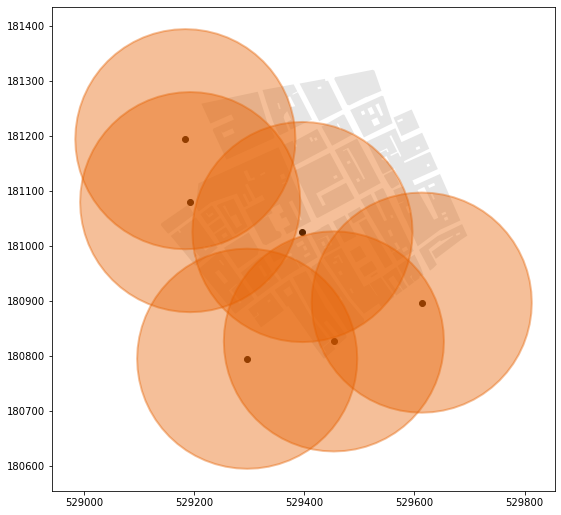

In [6]:
f, ax = plt.subplots(1, figsize=(9, 9))
blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
pumps['geometry'].plot(ax=ax, color='black')
pumps['buffer'].plot(ax=ax, linewidth=2, edgecolor='#e66101', facecolor='#e66101', alpha=0.4)

We'll use the last map we created as a 'basemap' to visualise other operations in this notebook, so let's create a function we can use for that here, before moving on:

In [7]:
def plot_operations_basemap(opObject):
    f, ax = plt.subplots(1, figsize=(9, 9))
    blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
    pumps['geometry'].plot(ax=ax, color='black')
    pumps['buffer'].plot(ax=ax, linewidth=2, edgecolor='#e66101', facecolor='#e66101', alpha=0.4)
    gpd.GeoSeries(opObject).plot(ax=ax, linewidth=2, edgecolor='#5e3c99', facecolor='#5e3c99', alpha=0.4)  

# Differences <a id='diff'></a>

## Difference
A _difference_ spatial operation compares two objects for their overlap. In set theory this is known as the [relative complement](https://en.wikipedia.org/wiki/Complement_(set_theory)#Relative_complement). In Shapely, we use the [`difference` method](https://shapely.readthedocs.io/en/stable/manual.html#object.difference):

> Returns a representation of the points making up this geometric object that do not make up the other object.

[Another way to put it](https://developers.arcgis.com/python/guide/part3-spatial-operations-on-geometries/#a2.-Difference) is that a difference operation:

> constructs the geometry that is composed only of the region unique to the base geometry but not part of the second geometry. 

So, we can't just apply `difference` to an entire Series of geometric objects as we did for `buffer`. Instead, we need to specify one 'focal' object and another against which to compare (similar to how we use the [`distance` method](https://shapely.readthedocs.io/en/stable/manual.html#object.distance)). 

Let's select the buffers of two pumps from the GeoDataFrame using the `name` Series:

In [8]:
bufA=pumps[pumps['name']=='Broad St Pump']['buffer'].squeeze()  #squeeze needed to return the geometric object
bufB=pumps[pumps['name']=='Rupert St Pump']['buffer'].squeeze()

Now, assuming the Broad St Pump is our focal pump, we can identify the difference between that buffer and the buffer for Rupert St Pump:

In [9]:
AdiffB = bufA.difference(bufB)

And now plot this the object created:

<AxesSubplot:>

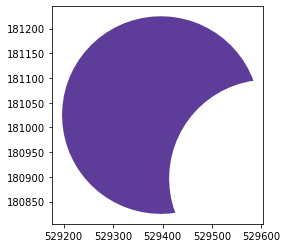

In [10]:
gpd.GeoSeries(AdiffB).plot(facecolor='#5e3c99')   #need to convert to GeoSeries to plot, see https://stackoverflow.com/a/62837292

We can see a section of the Broad St Pump buffer has been removed. This is the section that overlapped (in space) the buffer of Rupert St Pump. 

Plotting in context of the pumps and buffers helps to see this: 

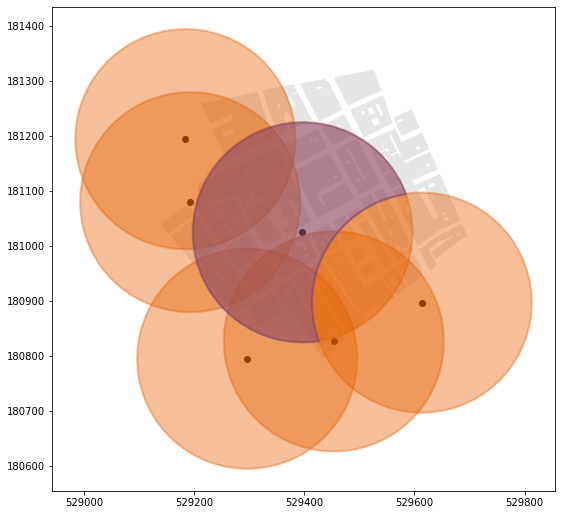

In [11]:
plot_operations_basemap(AdiffB)  #using our function from above

To see why it matters which is the focal object, let's calculate the difference the other way around:

In [12]:
BdiffA = bufB.difference(bufA)

And now plot:

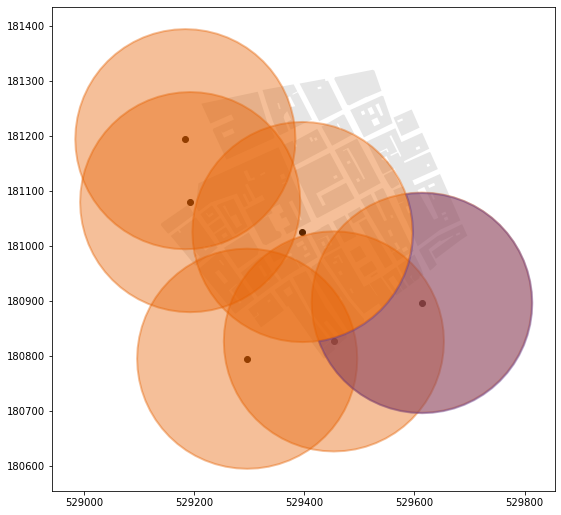

In [13]:
plot_operations_basemap(BdiffA)  #using our function from above

## Symmetric Difference

What if we want to find the area of two objects that do not overlap? This is known as [Symmetric Difference](https://en.wikipedia.org/wiki/Symmetric_difference) and in set theory this area would be the [union without the intersection](https://en.wikipedia.org/wiki/Symmetric_difference) (two more operations we'll see below). With Shapely we create an object representing this area using the [`symmetric_difference`](https://shapely.readthedocs.io/en/stable/manual.html#object.symmetric_difference) method:

> Returns a representation of the points in this object not in the _other_ geometric object, and the points in the _other_ not in this geometric object.

So again, we specify two objects to compare:

In [14]:
AsdB = bufA.symmetric_difference(bufB)

And plot to visualise:

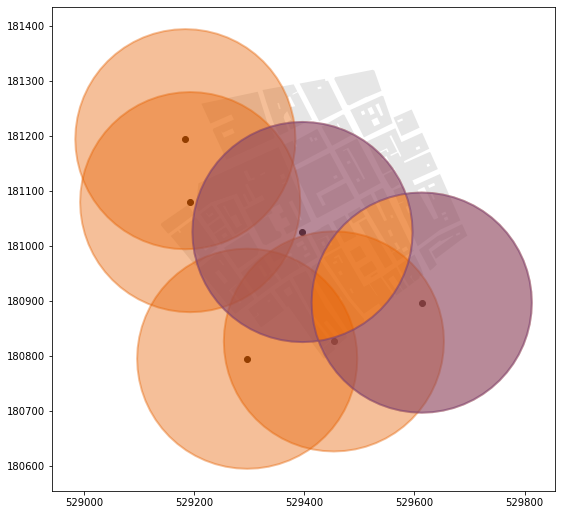

In [15]:
plot_operations_basemap(AsdB)  #using our function from above

# Intersection <a id='inter'></a>

In set theory, an [_intersection_](https://en.wikipedia.org/wiki/Intersection_(set_theory)) is the _"set containing all elements of A that also belong to B"_. In space, we can think of this as the area of two geometric objects that overlap. In Shapely, we can use the [`intersection` method](https://shapely.readthedocs.io/en/stable/manual.html#object.intersection), which:

> Returns a representation of the intersection of this object with the _other_ geometric object.

So, again we need to specify two objects:

In [16]:
AintB = bufA.intersection(bufB)

And plot:

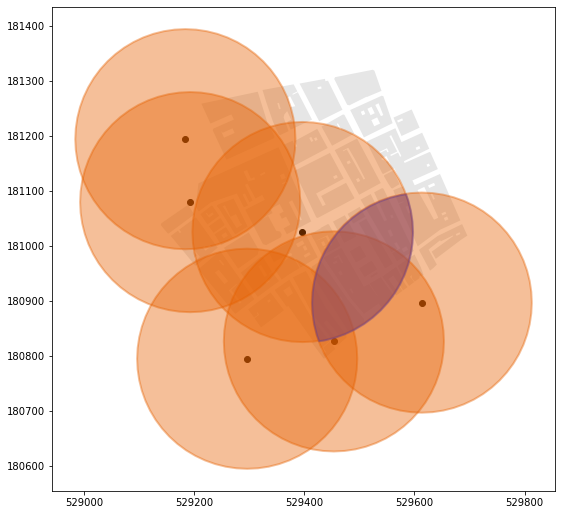

In [17]:
plot_operations_basemap(AintB)  #using our function from above

We can see that the area of the intersection (purple) is that shared by the buffers of both of the pumps we are interested in. 

For `intersection`, it makes no difference which object we specify as the 'focal' object. To check this, let's reverse the objects in the last use of `intersection`:   

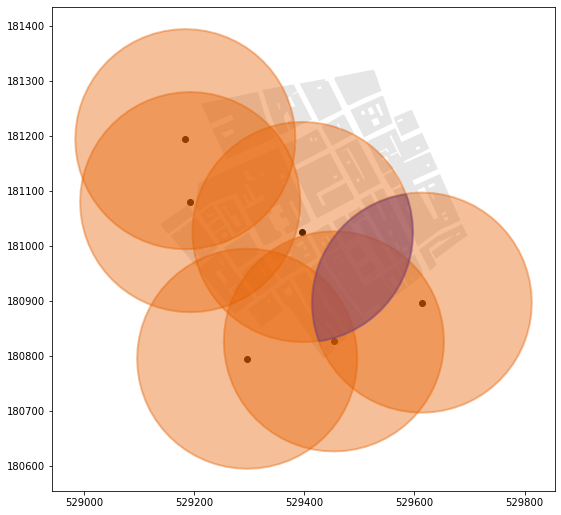

In [18]:
BintA = bufB.intersection(bufA)

plot_operations_basemap(BintA)  #using our function from above

Think about what the intersection means for people living in this area and their proximity to the two pumps.  

# Union <a id='union'></a>

The final operation we'll look at here, before considering how we can combine some of these operations, is [union](https://en.wikipedia.org/wiki/Union_(set_theory)). In space, union is the combined area of two or more geometric objects, including both the sections that overlap (intersection) and those that do not (symmetric difference). 

## Two objects

To create the union of two objects in Shapely, we can use the [`union` method](https://shapely.readthedocs.io/en/stable/manual.html#object.union) which: 

> Returns a representation of the union of points from this object and the _other_ geometric object.

So, again we need to specify two objects:

In [19]:
AunionB = bufA.union(bufB)

Now when we plot, note how the outline of the union object does not complete two circles:

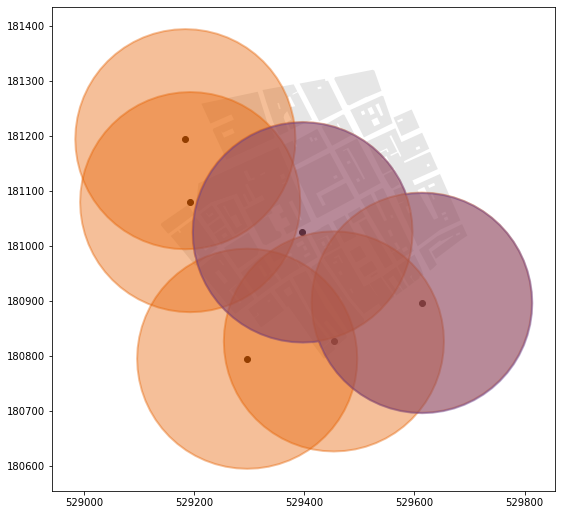

In [20]:
plot_operations_basemap(AunionB)  #using our function from above

To be a little clearer about what we mean by not creating two circles, let's plot without any context:

<AxesSubplot:>

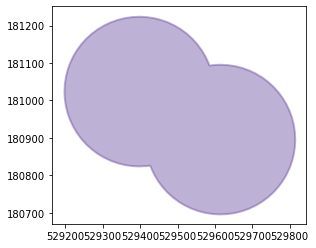

In [21]:
gpd.GeoSeries(AunionB).plot(linewidth=2, edgecolor='#5e3c99', facecolor='#5e3c99', alpha=0.4) 

## More than two objects

When we want to create a union of >2 objects, Shapely note that the [`unary_union`](https://shapely.readthedocs.io/en/stable/manual.html#shapely.ops.unary_union) is more efficient. Because `unary_union` is for more than two objects, we use it more like the `buffer` method than the other methods we've been looking at in this notebook:

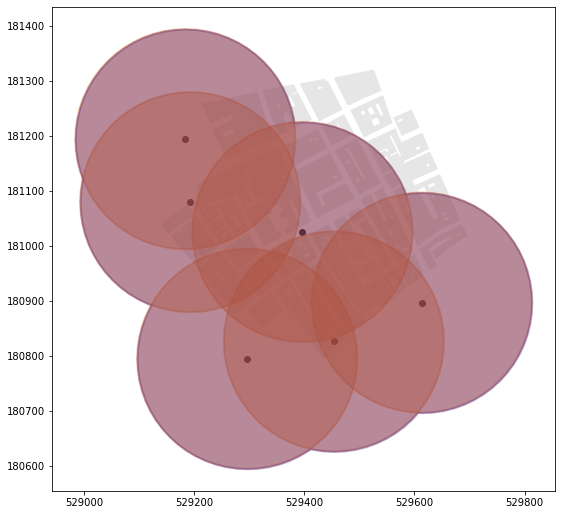

In [22]:
unionBuffs = shapely.ops.unary_union(pumps['buffer'].tolist())    #convert Series to list for unary_union to work
plot_operations_basemap(unionBuffs)  #using our function from above

Again, it's a little difficult to see that we've created a single object. So plotting without context:

<AxesSubplot:>

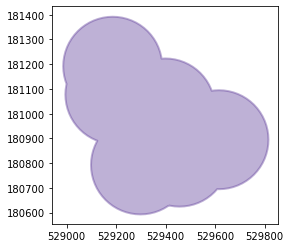

In [23]:
gpd.GeoSeries(unionBuffs).plot(linewidth=2, edgecolor='#5e3c99', facecolor='#5e3c99', alpha=0.4) 

And compare this to plotting all the buffers:

<AxesSubplot:>

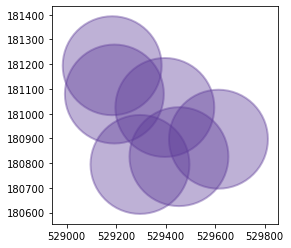

In [24]:
gpd.GeoSeries(pumps['buffer']).plot(linewidth=2, edgecolor='#5e3c99', facecolor='#5e3c99', alpha=0.4) 

So now we can see that the former plot really is a single object representing the footprint of the entire area within 200m of any pump. 

# Combining Operations <a href="#combine">

Let's say we wanted to find the area within 200m or Broad St. Pump, but not within  200m of any other pump. We can create an object representing that area using a combination of the operations we've seen above. 

First, get all buffers except Broad St Pump and create a union of these:

<AxesSubplot:>

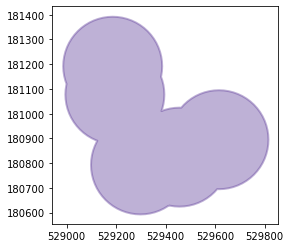

In [25]:
OtherBuffs = pumps[pumps['name']!='Broad St Pump']['buffer'].tolist()  #convert Series to list for unary_union to work
unionOtherBuffs = shapely.ops.unary_union(OtherBuffs)
gpd.GeoSeries(unionOtherBuffs).plot(linewidth=2, edgecolor='#5e3c99', facecolor='#5e3c99', alpha=0.4)

Now, we'll visualise this new single polygon in context with the buffer of Broad St Pump:

<AxesSubplot:>

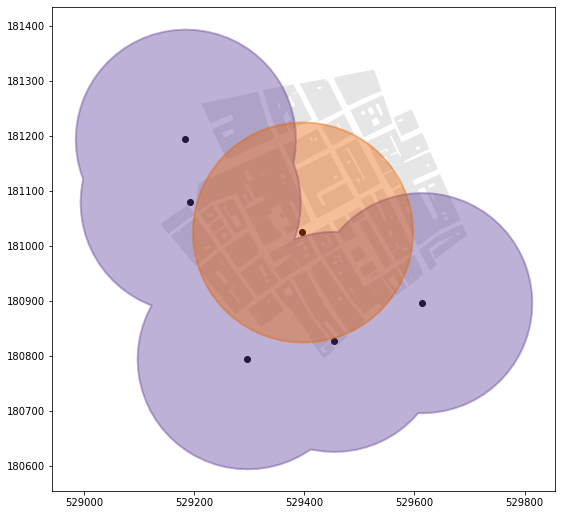

In [26]:
f, ax = plt.subplots(1, figsize=(9, 9))
blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
pumps['geometry'].plot(ax=ax, color='black')
gpd.GeoSeries(unionOtherBuffs).plot(ax=ax,linewidth=2, edgecolor='#5e3c99', facecolor='#5e3c99', alpha=0.4)
gpd.GeoSeries(bufA).plot(ax=ax, linewidth=2, edgecolor='#e66101', facecolor='#e66101', alpha=0.4)  

Using that visualisation, think about what operation we could use to create an object representing the area within 200m or Broad St. Pump, but not within  200m of any other pump...

We need to use the _difference_ method:

In [27]:
AdiffuOB = bufA.difference(unionOtherBuffs)

And plot in context to check:

<AxesSubplot:>

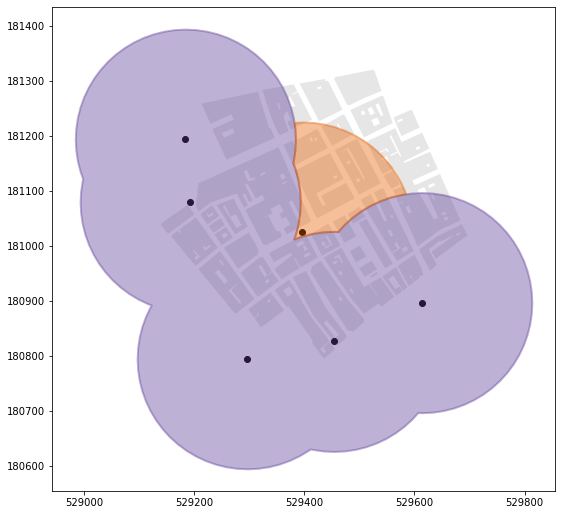

In [28]:
f, ax = plt.subplots(1, figsize=(9, 9))
blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
pumps['geometry'].plot(ax=ax, color='black')
gpd.GeoSeries(unionOtherBuffs).plot(ax=ax,linewidth=2, edgecolor='#5e3c99', facecolor='#5e3c99', alpha=0.4)
gpd.GeoSeries(AdiffuOB).plot(ax=ax, linewidth=2, edgecolor='#e66101', facecolor='#e66101', alpha=0.4)  

Think about how these operations help us to visualise and understanding which pump people in Soho might have visited to get their water in 1854. 

# Further Activities

- Explore [merging operations on linear features](https://shapely.readthedocs.io/en/latest/manual.html?highlight=linemerge#merging-linear-features), such as `polygonize` and `linemerge`   
- Investigate [other Shapely operations functions](https://shapely.readthedocs.io/en/latest/manual.html#spatial-analysis-methods), such as `convex_hull` and `simplify`
- Continue to the next notebook to learn about [Voronoi Diagrams](https://en.wikipedia.org/wiki/Voronoi_diagram) (aka Thiessen Polygons)

# Credits!

## Contributors:
The following individual(s) have contributed to these teaching materials: James Millington (james.millington@kcl.ac.uk).

Colours selected from [ColorBrewer2](https://colorbrewer2.org/?type=diverging&scheme=PuOr&n=4)

## License
These teaching materials are licensed under a mix of [The MIT License](https://opensource.org/licenses/mit-license.php) and the [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 license](https://creativecommons.org/licenses/by-nc-sa/4.0/).